In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('paper')
sns.set_style('darkgrid')

**Setting Initial Conditions for Wall Accelerating to U at *t*=0, C=0.1**

In [2]:
y_min = 0.0
y_max = 1.0

u_min = 0.0
u_max = 1.0

t_min = 0.0
t_max = 2.0

y_step = 0.1
t_step = 0.001

y_array = np.arange(y_min, y_max+y_step, y_step)
t_array = np.arange(t_min, t_max+t_step, t_step)
y_spacing = len(y_array)
t_spacing = len(t_array)
u_grid = np.zeros((y_spacing, t_spacing))

#Setting Initial Conditions
u_grid[0, :] = u_max

In [3]:
def heat_slope_func(u_array, y_step, v=1.0):
    d2u_dy2_array = np.copy(u_array)
    for i in range(0, len(u_array)-1):
        d2u_dy2_array[i] = (u_array[i+1] + u_array[i-1] - 2.0*u_array[i])/(y_step**2.0)
    d2u_dy2_array[-1] = 0.0
    d2u_dy2_array[0] = 0.0
    return v*d2u_dy2_array

Note that we solve the implicit Euler scheme with an iterative fixed-point method instead of a Newton-Rhapson solver.

Implicit Euler:
$u_{j+1} = u_{j} + h\times\frac{du_{j+1}}{dt}$

For an initial guess of $\frac{du^{[0]}_{j+1}}{dt}$ we use $\frac{du_{j}}{dt}$.
Then $u^{[i]}_{j+1} = u_{j} + h\times\frac{du^{[i-1]}_{j+1}}{dt}$ until $\frac{|u^{[i]} - u^{[i-1]}|}{u^{[i-1]}} < 10^{-16}$ or $i = 1000$.

For the Crank-Nicholson (CN) we combined the implicit backwards Euler (BE) with the forward Euler (FE):
$\frac{du^{\mathrm{CN}}}{dt} = \frac{1}{2}\times (\frac{du^{\mathrm{BE}}}{dt} + \frac{du^{\mathrm{FE}}}{dt})$

Where $\frac{du^{\mathrm{FE}}}{dt} = \frac{du_{j}}{dt}$ and $\frac{du^{\mathrm{BE}}}{dt} = \frac{du_{j+1}}{dt}$. We use an iterative method as above for the same tolerance conditions.

In [4]:
def forward_euler_t(heat_slope_func, u_old, t_old, y_step, t_step=t_step, v=1.0):
    return u_old + t_step*heat_slope_func(u_old, y_step, v=v)

def backward_euler_t(heat_slope_func, u_old, t_old, y_step, t_step=t_step, v=1.0, tol=1.0e-16, max_iter=1000):
    t_new = t_old + t_step
    u_guess = forward_euler_t(heat_slope_func, u_old, t_old, y_step, t_step=t_step, v=v)
    error = 0.1
    counter = 0
    while error > tol:
        u_new = u_old + t_step*heat_slope_func(u_guess, y_step, v=v)
        error = np.nanmedian(np.abs(u_new - u_guess)/u_guess)
        u_guess = u_new
        counter += 1
        if counter > max_iter:
            #print("Did not converge within ", max_iter, ' iterations')
            error = tol/10.0
    return u_new

def crank_nicholson_t(heat_slope_func, u_old, t_old, y_step, t_step=t_step, v=1.0, tol=1.0e-6, max_iter=1000):
    forward_slope = heat_slope_func(u_old, y_step, v=v)
    u_guess = u_old + t_step*forward_slope
    error = 0.1
    counter = 0
    while error > tol:
        test_slope = 0.5*(heat_slope_func(u_old, y_step, v=v) + heat_slope_func(u_guess, y_step, v=v))
        u_new = u_old + t_step*test_slope
        error = np.nanmedian(np.abs(u_new - u_guess)/u_guess)
        u_guess = u_new
        counter += 1
        if counter > max_iter:
            #print("Did not converge within ", max_iter, ' iterations')
            error = tol/10.0
    return u_new

def integrate_t(u_grid_old, method_func, heat_slope_func, t_array, y_step, t_step=t_step, v=1.0):
    u_grid_new = np.copy(u_grid_old)
    for i in range(0, len(t_array)-1):
        u_old = u_grid_new[:, i]
        t_old = t_array[i]
        u_grid_new[:, i+1] = method_func(heat_slope_func, u_old, t_old, y_step, t_step=t_step, v=v)
    return u_grid_new

In [5]:
u_grid_euler = integrate_t(u_grid, forward_euler_t, heat_slope_func, t_array, y_step)
u_grid_crank = integrate_t(u_grid, crank_nicholson_t, heat_slope_func, t_array, y_step)
u_grid_euler_049 = integrate_t(u_grid, forward_euler_t, heat_slope_func, t_array, y_step, v=4.9)
u_grid_crank_049 = integrate_t(u_grid, crank_nicholson_t, heat_slope_func, t_array, y_step, v=4.9)
u_grid_euler_051 = integrate_t(u_grid, forward_euler_t, heat_slope_func, t_array, y_step, v=5.1)
u_grid_crank_051 = integrate_t(u_grid, crank_nicholson_t, heat_slope_func, t_array, y_step, v=5.1)
u_grid_euler_055 = integrate_t(u_grid, forward_euler_t, heat_slope_func, t_array, y_step, v=5.5)
u_grid_crank_055 = integrate_t(u_grid, crank_nicholson_t, heat_slope_func, t_array, y_step, v=5.5)


/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


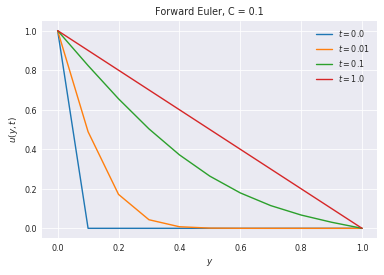

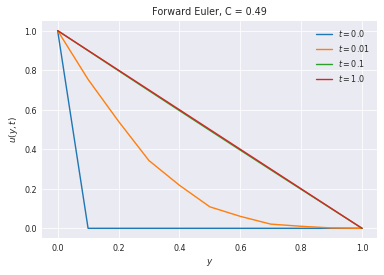

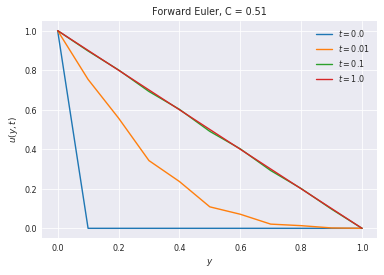

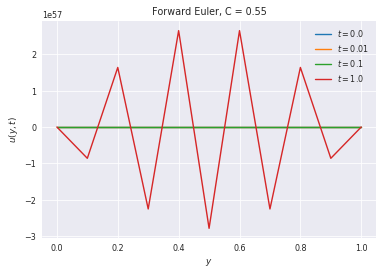

In [6]:
plt.plot(y_array, u_grid_euler[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.1')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_049[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_049[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_049[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_049[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.49')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_051[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_051[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_051[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_051[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.51')
plt.legend()
plt.show()

plt.plot(y_array, u_grid_euler_055[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_euler_055[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_euler_055[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_euler_055[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.55')
plt.legend()
plt.show()

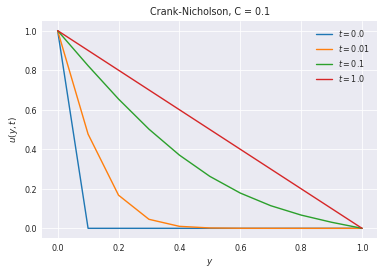

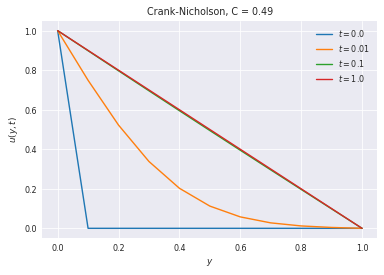

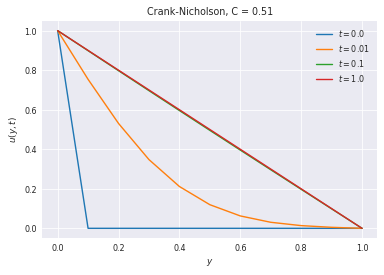

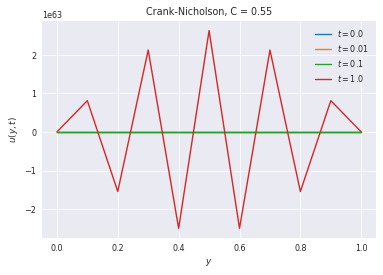

In [7]:
plt.title('Crank-Nicholson, C = 0.1')
plt.plot(y_array, u_grid_crank[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicholson, C = 0.49')
plt.plot(y_array, u_grid_crank_049[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_049[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_049[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_049[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicholson, C = 0.51')
plt.plot(y_array, u_grid_crank_051[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_051[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_051[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_051[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

plt.title('Crank-Nicholson, C = 0.55')
plt.plot(y_array, u_grid_crank_055[:, 0], label=r'$t=$' + str(t_array[0]))
plt.plot(y_array, u_grid_crank_055[:, 10], label=r'$t=$' + str(t_array[10]))
plt.plot(y_array, u_grid_crank_055[:, 100], label=r'$t=$' + str(t_array[100]))
plt.plot(y_array, u_grid_crank_055[:, 1000], label=r'$t=$' + str(t_array[1000]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.legend()
plt.show()

My implicit scheme is not stable for $C > 0.5$, indicating that my iterative method does not work properly. The explicit scheme blows up as expected. Perhaps the error introduced by the first forward Euler step for the initial guess is sufficient to render this scheme ineffectively implicit. A better version would be Gauss' elimination method to solve the matrix.

**Implementing an Oscillating Boundary**

In [8]:
y_min = 0.0
y_max = 1.0

u_min = 0.0
u_max = 1.0

t_min = 0.0
t_max = 2.0

y_step = 0.1
t_step = 0.0001

y_osc = np.arange(y_min, y_max+y_step, y_step)
t_osc = np.arange(t_min, t_max+t_step, t_step)
y_osc_spacing = len(y_osc)
t_osc_spacing = len(t_osc)
u_grid_osc = np.zeros((y_osc_spacing, t_osc_spacing))

#Setting Initial Conditions
omega = 1.0*np.pi/2.0
u_grid_osc[0, :] = np.cos(omega*t_osc)
u_grid_osc[-1, :] = -1.0

In [9]:
u_grid_euler_osc = integrate_t(u_grid_osc, forward_euler_t, heat_slope_func, t_osc, y_step)
u_grid_crank_osc = integrate_t(u_grid_osc, crank_nicholson_t, heat_slope_func, t_osc, y_step)

/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


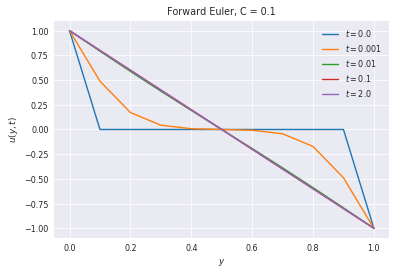

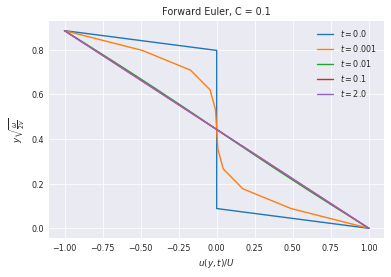

In [10]:
plt.plot(y_osc, u_grid_euler_osc[:, 0], label=r'$t=$' + str(t_osc[0]))
plt.plot(y_osc, u_grid_euler_osc[:, 10], label=r'$t=$' + str(t_osc[10]))
plt.plot(y_osc, u_grid_euler_osc[:, 100], label=r'$t=$' + str(t_osc[100]))
plt.plot(y_osc, u_grid_euler_osc[:, 1000], label=r'$t=$' + str(t_osc[1000]))
plt.plot(y_osc, u_grid_euler_osc[:, -1], label=r'$t=$' + str(t_osc[-1]))
plt.ylabel(r'$u(y, t)$')
plt.xlabel(r'$y$')
plt.title('Forward Euler, C = 0.1')
plt.legend()
plt.show()

laminar_flow = y_osc*np.sqrt(omega/(2.0))
plt.plot(u_grid_euler_osc[:, 0], laminar_flow,label=r'$t=$' + str(t_osc[0]))
plt.plot(u_grid_euler_osc[:, 10], laminar_flow,label=r'$t=$' + str(t_osc[10]))
plt.plot(u_grid_euler_osc[:, 100], laminar_flow,label=r'$t=$' + str(t_osc[100]))
plt.plot(u_grid_euler_osc[:, 1000], laminar_flow,label=r'$t=$' + str(t_osc[1000]))
plt.plot(u_grid_euler_osc[:, 1000], laminar_flow,label=r'$t=$' + str(t_osc[-1]))
plt.xlabel(r'$u(y, t)/U$')
plt.ylabel(r'$y\sqrt{\frac{\omega}{2v}}$')
plt.title('Forward Euler, C = 0.1')
plt.legend()
plt.show()

